In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
##### LOAD DATA

sample_count = 9000

X_dev = np.load(f"data/base_data/MNIST_X_dev_{sample_count}_data.npy")
y_dev = np.load(f"data/base_data/MNIST_y_dev_{sample_count}_data.npy")

In [3]:
batch_size = 128
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128


# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_images = X_dev.astype("float32") / 255.0
all_images = np.reshape(all_images, (-1, 28, 28, 1))
all_labels = tf.keras.utils.to_categorical(y_dev, 10)


# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")


generator_in_channels = latent_dim
discriminator_in_channels = num_channels

Shape of training images: (9000, 28, 28, 1)
Shape of training labels: (9000, 10)


In [4]:
def generator(dim = 7,  dropout = 0.25, kshape = (5,5)):

    #label input
    label_input = tf.keras.layers.Input((num_classes))
    label_dense = tf.keras.layers.Dense(dim*dim*1, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(label_input)
    label_reshape = tf.keras.layers.Reshape((7,7,1))(label_dense)

    random_input = tf.keras.layers.Input(generator_in_channels)
    x1 = tf.keras.layers.Dense(dim*dim*generator_in_channels, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(random_input)
    x2 = tf.keras.layers.Reshape((7,7,generator_in_channels))(x1)

    #concat the layers
    x3 = tf.keras.layers.Concatenate()([x2,label_reshape])

    x4 = tf.keras.layers.Conv2DTranspose(256,(4,4),strides=(2,2),activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same")(x3)
    x5 = tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same")(x4)
    x6 = tf.keras.layers.Conv2D(1,(7,7),padding="same",activation="sigmoid")(x5)

    model = tf.keras.models.Model(inputs=[random_input,label_input], outputs=x6)
    return model

generator_model = generator()
#print(generator_model.summary())


def discriminator(dim=7):
    #label input
    label_input = tf.keras.layers.Input((num_classes))
    label_dense = tf.keras.layers.Dense(dim*dim*2*2, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(label_input)
    label_reshape = tf.keras.layers.Reshape((14,14,1))(label_dense)

    #input image
    x1 = tf.keras.layers.Input((image_size,image_size,1))
    x2 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding="same")(x1)

    x3 = tf.keras.layers.Concatenate()([x2,label_reshape])
    x4 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2),activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding="same")(x3)
    globalmaxpool = tf.keras.layers.GlobalMaxPooling2D()(x4)
    final_layer = tf.keras.layers.Dense(1,activation="sigmoid")(globalmaxpool)

    model = tf.keras.models.Model(inputs=[x1,label_input], outputs=final_layer)
    return model

discriminator_model = discriminator()

In [5]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode the noise (guided by labels) to fake images.
        fake_images = self.generator([random_latent_vectors,one_hot_labels])
        fake_labels = one_hot_labels

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        all_images = tf.concat([fake_images,real_images],axis=0)
        all_labels = tf.concat([one_hot_labels,one_hot_labels],axis=0)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator([all_images,all_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size*2, self.latent_dim))


        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size*2, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors,all_labels])
            #fake_labels = tf.concat([one_hot_labels,one_hot_labels],axis=0)
            predictions = self.discriminator([fake_images,all_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [6]:
cond_gan = ConditionalGAN(
    discriminator=discriminator_model, generator=generator_model, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.RMSprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8),
    g_optimizer=tf.keras.optimizers.RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 3e-8),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

/home/rodrigo/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [7]:
cond_gan.fit(dataset, epochs=200)

Epoch 1/200


/home/rodrigo/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


71/71 [==============================] - 6s 47ms/step - g_loss: 0.9374 - d_loss: 0.4836
Epoch 2/200
71/71 [==============================] - 3s 43ms/step - g_loss: 1.1665 - d_loss: 0.4753
Epoch 3/200
71/71 [==============================] - 3s 44ms/step - g_loss: 1.0207 - d_loss: 0.5635
Epoch 4/200
71/71 [==============================] - 3s 44ms/step - g_loss: 0.9245 - d_loss: 0.5966
Epoch 5/200
71/71 [==============================] - 3s 44ms/step - g_loss: 0.9403 - d_loss: 0.5967
Epoch 6/200
71/71 [==============================] - 3s 44ms/step - g_loss: 0.9734 - d_loss: 0.5476
Epoch 7/200
71/71 [==============================] - 3s 44ms/step - g_loss: 1.0739 - d_loss: 0.5086
Epoch 8/200
71/71 [==============================] - 3s 44ms/step - g_loss: 1.1848 - d_loss: 0.4648
Epoch 9/200
71/71 [==============================] - 3s 44ms/step - g_loss: 1.2584 - d_loss: 0.4471
Epoch 10/200
71/71 [==============================] - 3s 44ms/step - g_loss: 1.2909 - d_loss: 0.4416
Epoch 11/20

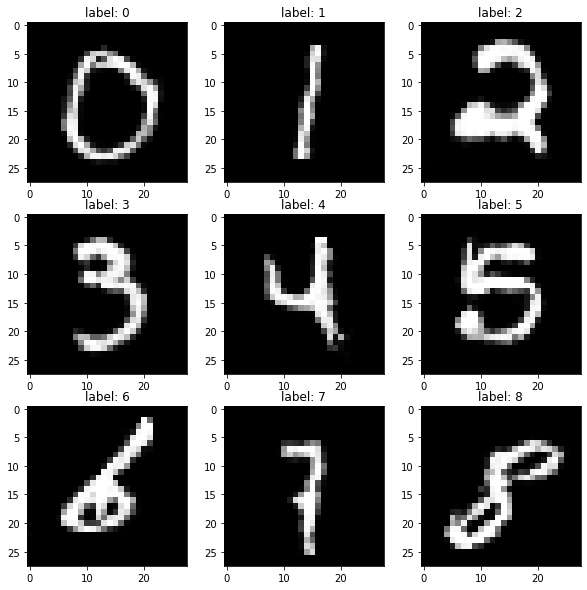

In [8]:
trained_gen = cond_gan.generator



interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=10)
interpolation_noise = tf.reshape(interpolation_noise, (10, latent_dim))


labels = tf.keras.utils.to_categorical(list(range(0,10)), num_classes)
#labels = keras.utils.to_categorical(list([7]*10), num_classes)

# Combine the noise and the labels and run inference with the generator.
noise_and_labels = tf.concat([interpolation_noise, labels], 1)
fake = trained_gen.predict([interpolation_noise,labels])



fig,ax = plt.subplots(3,3)

fig.set_figheight(10)
fig.set_figwidth(10)


for i in range(0,3):
    for j in range(0,3):
        ax[i,j].imshow(fake[i*3+j],cmap='gray')
        ax[i,j].set_title(f"label: {i*3+j}")

In [9]:
#save generator model

trained_gen.save(f"gan_models/trained_gen_{sample_count}.h5")